## Installing mrjob 

Before we start we need to install the mrjob package. This package converts our python script to a MapReduce job through Hadoop Streaming. 



In [ ]:
%pip install mrjob 

     |████████████████████████████████| 439 kB 5.0 MB/s 


### Movie Ratings Dataset

Before we start with the MapReduce example, we will get a short overview over the movie_ratings dataset.

In [ ]:
import pandas as pd

# The used dataset has no headers row, so we have to set header=None
# 
df = pd.read_csv("movie_ratings.data", sep="\t", header=None)

In [ ]:
df.head()

0             1  2          3
0  196  Kolya (1996)  3  881250949
1   63  Kolya (1996)  3  875747190
2  226  Kolya (1996)  5  883888671
3  154  Kolya (1996)  3  879138235
4  306  Kolya (1996)  5  876503793

The columns are: movieID, title, rating and timestamp

In [ ]:
# We have 100.000 movie ratings
df.shape

(100000, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       100000 non-null  int64 
 1   1       100000 non-null  object
 2   2       100000 non-null  int64 
 3   3       100000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


In [ ]:
# The describe()-method doesn't say much in this case since statistics for IDs and dates aren't that helpful.
# Only for ratings it gives some insights (but also not that much)
df.describe()

0              2             3
count  100000.00000  100000.000000  1.000000e+05
mean      462.48475       3.529860  8.835289e+08
std       266.61442       1.125674  5.343856e+06
min         1.00000       1.000000  8.747247e+08
25%       254.00000       3.000000  8.794487e+08
50%       447.00000       4.000000  8.828269e+08
75%       682.00000       4.000000  8.882600e+08
max       943.00000       5.000000  8.932866e+08

## First MapReduce Job

We will just look at a simple example. We are interested if the ratings are equally distributed, i.e. if each rating from 1 to 5 stars has aprroximatley the same number of occurencies. 

For that we implement a mapper-function that simply goes through each row an returns a key-value pair in the form of rating, 1. 

These key value pairs are automatically shuffled and sorted and handed over to the reduce function, which just adds up the "1"s. 

We could just implement these functions in Python without hadoop. But with help of the mrjob package we can theoretically precess our code within a Hadoop cluster without much more effort. 

Important: When using the mrjob-package, we have to use the "yield"-function instead of the "return" function. Simply said: "yield" returns results one by one and "return" returns the whole result.

Reminder: MapReduce automatically sorts results by keys!

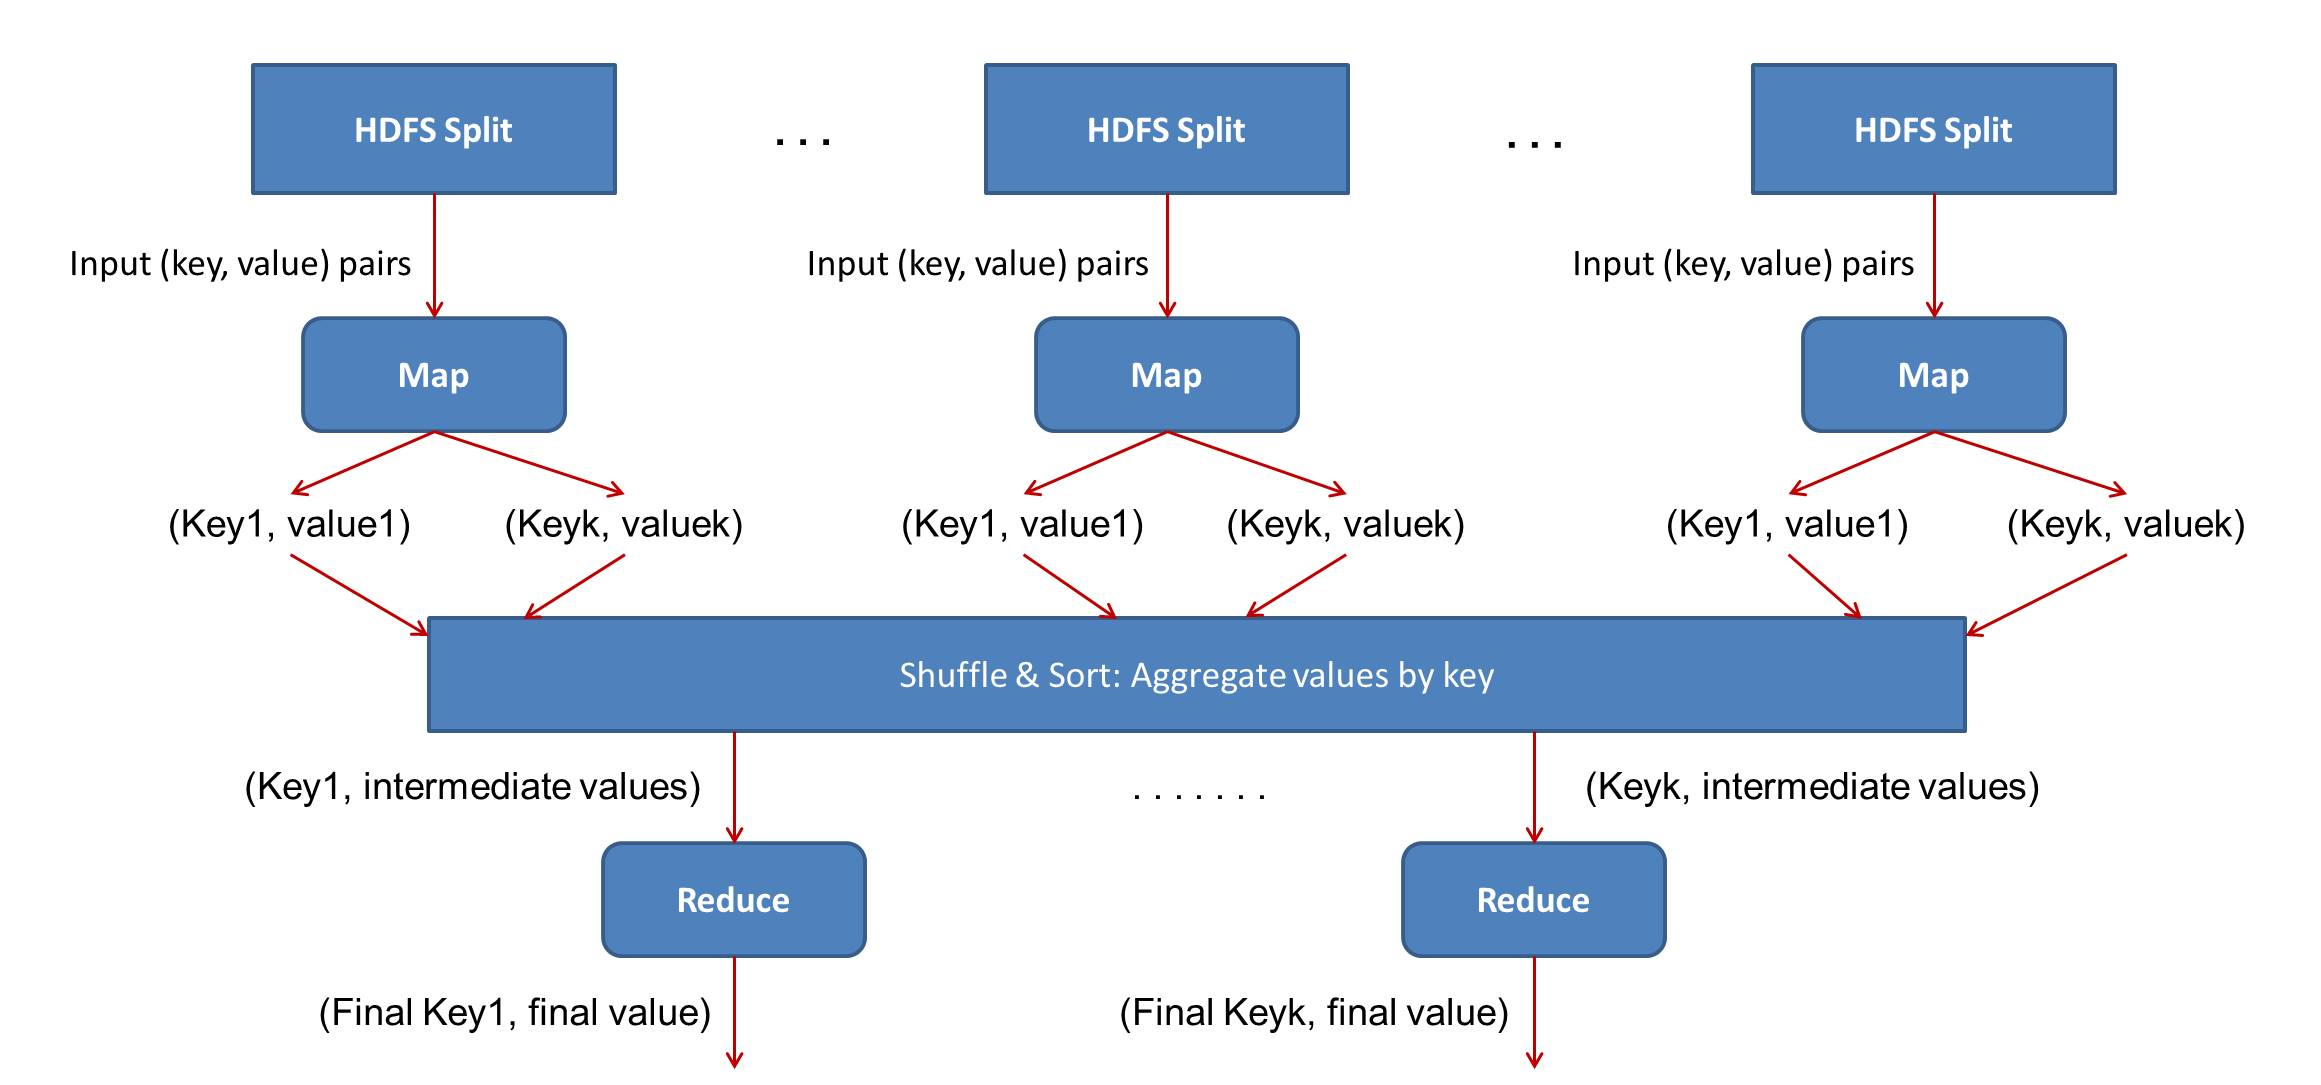

In [ ]:
# %% file saves this code as a python file
%%file RatingsBreakdown.py

from mrjob.job import MRJob 
from mrjob.step import MRStep 

class RatingsBreakdown(MRJob):

  def steps(self):
    return [
            MRStep(mapper=self.mapper, 
                   reducer=self.reducer)
    ]
  
  # By using the mrjob package we have to give all mappers and reducers three arguements
  # The first argument has to be "self" as always within classes
  # The second arguement is a key, which can be ignored in this case, because we just have one step
  # If we would need a second mapper after the first step, we had to define the key_name here
  # The third argument is the value, which is just each line/row of our dataset
  def mapper(self, _, line):
    (userID, movie, rating, timestamp) = line.split("\t")
    yield (rating, 1)

  def reducer(self, key, values):
    yield key, sum(values)

if __name__ == "__main__":
  RatingsBreakdown.run()

Overwriting RatingsBreakdown.py


In [ ]:
# Reminder: code starting with an "!" is executed in the terminal!
!python RatingsBreakdown.py movie_ratings.data

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/RatingsBreakdown.root.20211128.084955.377363
Running step 1 of 1...
job output is in /tmp/RatingsBreakdown.root.20211128.084955.377363/output
Streaming final output from /tmp/RatingsBreakdown.root.20211128.084955.377363/output...
"5"	21201
"1"	6110
"2"	11370
"3"	27145
"4"	34174
Removing temp directory /tmp/RatingsBreakdown.root.20211128.084955.377363...


In [ ]:
# Example: This command would run on the complete cluster!
!python RatingsBreakdown.py -r hadoop hdfs:///content/movie_ratings.data